In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from tqdm import tqdm
from collections import Counter
from scipy.spatial.distance import jensenshannon

from helpers.style import load_style
from helpers.visuals import add_cabinet_periods

load_style()

# Corpus Stats

In [12]:
# txt = pd.read_csv('/home/rb/Documents/Data/models/lda/postwar-v3/text.txt',header=None)
dat = pd.read_csv('/home/rb/Documents/Data/models/lda/postwar-v3/data.tsv',sep='\t')

In [14]:
dat['l'] = dat.lemm_cleaned.str.len()

In [16]:
d = dat.groupby(dat.date.str[:4]).l.sum()
d /= d.sum()

<Axes: xlabel='date'>

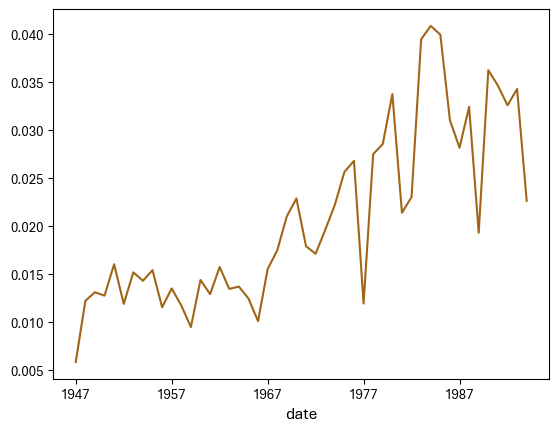

In [18]:
d.plot()

## Trends

In [5]:
# Import Metadata
metadata = pd.read_csv('/home/rb/Documents/Data/metadata/metadata-full.tsv',sep='\t',parse_dates=['date'])
metadata = metadata[metadata.session_type == 'plenary']
metadata['py'] = metadata.speech_id.str.split('.').str[4].str[:8]
metadata['sess'] = metadata.speech_id.str.split('.').str[4:6].agg('.'.join)

names = dict(zip(metadata['member-ref'],metadata.speaker))
parties = dict(zip(metadata['member-ref'],metadata['party-ref']))

# Date Dictionaries
dates_topic = dict(zip(metadata.speech_id.str.split('.').str[4:6].str.join('.'), metadata.date))
dates_speech = dict(zip(metadata.speech_id, metadata.date))

# Change dates to 6-month bins, select only MPs, Plenaries, and remove joint House meetings
subset = metadata[(metadata.role == 'mp') & (metadata.py.str[4:6] == '19') & (metadata.date.dt.year > 1945)]

/tmp/ipykernel_192216/1533170318.py:5: FutureWarning: using <built-in method join of str object at 0x7aa902f9f1b0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  metadata['sess'] = metadata.speech_id.str.split('.').str[4:6].agg('.'.join)


/tmp/ipykernel_192216/2601731561.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset.groupby('py').apply(lambda g: g.groupby('sess')['member-ref'].nunique().mean()).plot(ax=axs[0,1])
/tmp/ipykernel_192216/2601731561.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset.groupby('py').apply(lambda g: g.groupby('sess')['member-ref'].nunique().mean() / g['member-ref'].nunique()).plot(ax=atwi,color=

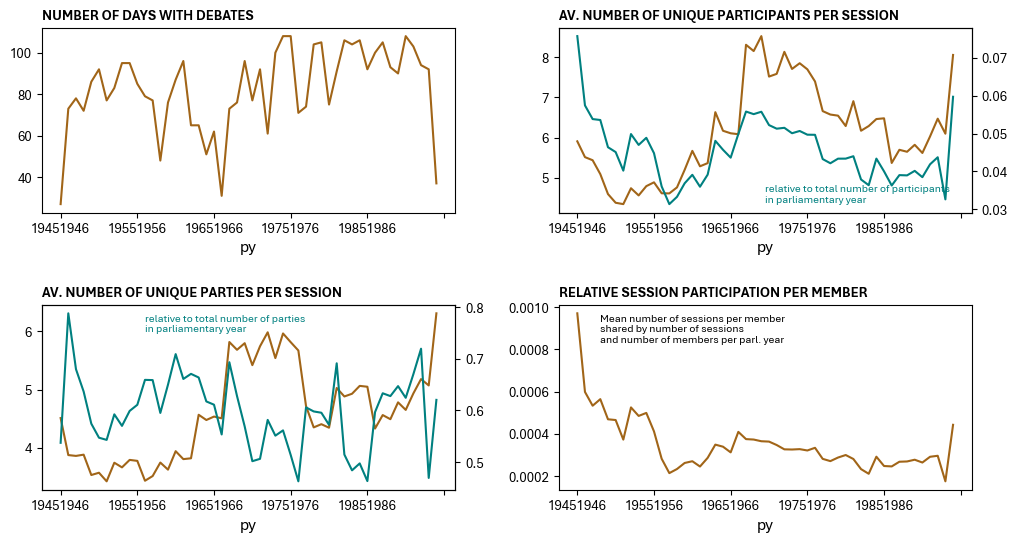

In [53]:
f, axs = plt.subplots(2,2,figsize=(12,6))

## Number of Dates per PY
subset.groupby('py').date.nunique().plot(ax=axs[0,0])
axs[0,0].set_title('NUMBER OF DAYS WITH DEBATES',fontweight='bold',loc='left')

## Av. Number of Participants per Session per PY
subset.groupby('py').apply(lambda g: g.groupby('sess')['member-ref'].nunique().mean()).plot(ax=axs[0,1])
atwi = axs[0,1].twinx()
subset.groupby('py').apply(lambda g: g.groupby('sess')['member-ref'].nunique().mean() / g['member-ref'].nunique()).plot(ax=atwi,color='teal')
axs[0,1].set_title('AV. NUMBER OF UNIQUE PARTICIPANTS PER SESSION',fontweight='bold',loc='left')
axs[0,1].text(0.5, 0.15, 'relative to total number of participants\nin parliamentary year', transform=axs[0,1].transAxes,fontsize=8, va='top',color='teal')

## Av. Number of Participating Parties per Session per PY
subset.groupby('py').apply(lambda g: g.groupby('sess')['party-ref'].nunique().mean()).plot(ax=axs[1,0])
atwi = axs[1,0].twinx()
subset.groupby('py').apply(lambda g: g.groupby('sess')['member-ref'].nunique().mean() / g['party-ref'].nunique()).plot(ax=atwi,color='teal')
axs[1,0].set_title('AV. NUMBER OF UNIQUE PARTIES PER SESSION',fontweight='bold',loc='left')
axs[1,0].text(0.25, 0.95, 'relative to total number of parties\nin parliamentary year', transform=axs[1,0].transAxes,fontsize=8, va='top',color='teal')

## Member participation Rate
subset.groupby('py').apply(lambda g:(g.groupby(['member-ref']).sess.nunique().mean() / g.sess.nunique()) / g['member-ref'].nunique()).plot(ax=axs[1,1])
axs[1,1].set_title('RELATIVE SESSION PARTICIPATION PER MEMBER',fontweight='bold',loc='left')
axs[1,1].text(0.1, 0.95, 'Mean number of sessions per member\nshared by number of sessions\nand number of members per parl. year', transform=axs[1,1].transAxes,fontsize=8, va='top')

plt.subplots_adjust(hspace=.5,wspace=.25)

plt.savefig('figs/metadata-sanity.png',dpi=400)